In [4]:
%matplotlib nbagg

import geofield
import dipole
import scipy, numpy
from matplotlib import pyplot, rcParams
rcParams.update({'font.family': "Source Sans Pro"})
rcParams.update({'font.size': 14})

In [70]:
import importlib
importlib.reload(dipole); importlib.reload(geofield)

<module 'geofield' from '/home/josecper/Programs/python/geofield.py'>

In [6]:
sha=geofield.SHADIFData("../data/sha.dif.14k/coef_EPSL_tnmgh.dat", "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

__Bootstrap__

In [89]:
iterations = 10000

xs = numpy.zeros((iterations,len(sha.years)))
ys = xs.copy()
zs = xs.copy()

gshort = sha.gcomp[..., :8]
gshort_err = sha.gcomp_err[..., :8] #doesn't exist yet

for i in range(iterations):
    gi = gshort+numpy.random.randn(*gshort.shape)*gshort_err
    xs[i,:], ys[i,:], zs[i,:] = dipole.ecc_dipole(gi)
    
x = xs.sum(axis=0)/iterations
y = ys.sum(axis=0)/iterations
z = zs.sum(axis=0)/iterations

ss, zs, phis = dipole.xyz2cyl(xs,ys,zs)
phis = phis % (2*numpy.pi)
rs = numpy.sqrt(xs**2+ys**2+zs**2)
s, z, phi = dipole.xyz2cyl(x,y,z)
phi = phi % (2*numpy.pi)
r = numpy.sqrt(x**2+y**2+z**2)

s_dev = numpy.sqrt(((ss-s)**2).sum(axis=0)/iterations)
z_dev = numpy.sqrt(((zs-z)**2).sum(axis=0)/iterations)
r_dev = numpy.sqrt(((rs-r)**2).sum(axis=0)/iterations)
phi_dev = numpy.sqrt(((phis-phi)**2).sum(axis=0)/iterations)

In [28]:
xs.shape

(1000, 279)

In [35]:
ss.shape

(1000, 279)

<IPython.core.display.Javascript object>


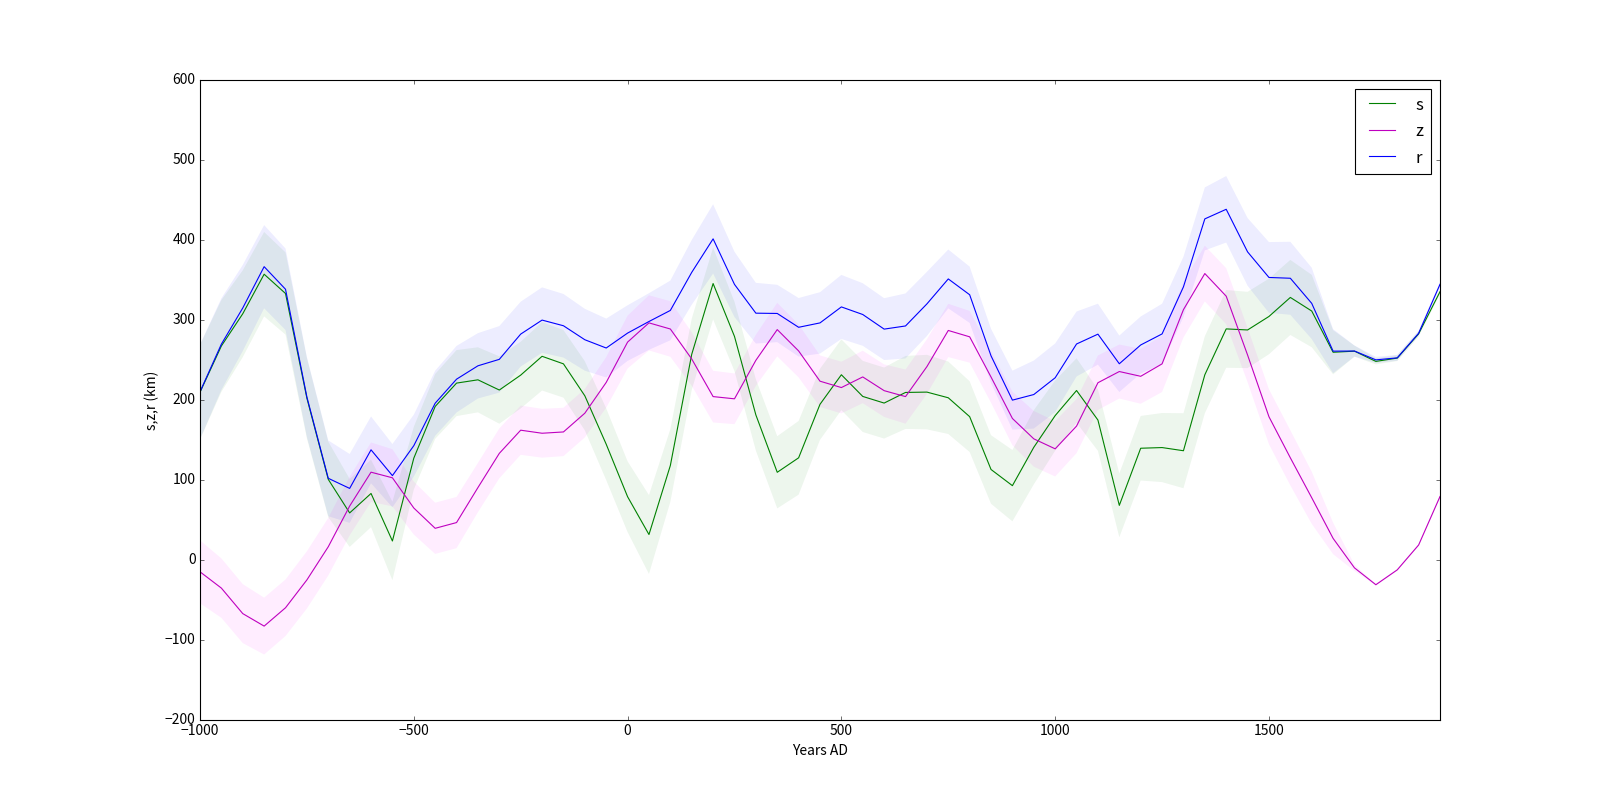

In [90]:
fig, ax = pyplot.subplots(figsize=(20,10))

ax.plot(sha.years, s, color="green", label="s")
ax.plot(sha.years, z, "m-", label="z")
ax.plot(sha.years, r, "b-", label="r")

ax.fill_between(sha.years, r-r_dev, r+r_dev, color="blue", lw=0, alpha=0.07)
ax.fill_between(sha.years, z-z_dev, z+z_dev, color="magenta", lw=0, alpha=0.07)
ax.fill_between(sha.years, s-s_dev, s+s_dev, color="green", lw=0, alpha=0.07)

ax.set_xlabel("Years AD")
ax.set_ylabel("s,z,r (km)")
ax.legend()

ax.set_xbound(-1000,sha.years[-1])

pyplot.show(fig)

<IPython.core.display.Javascript object>


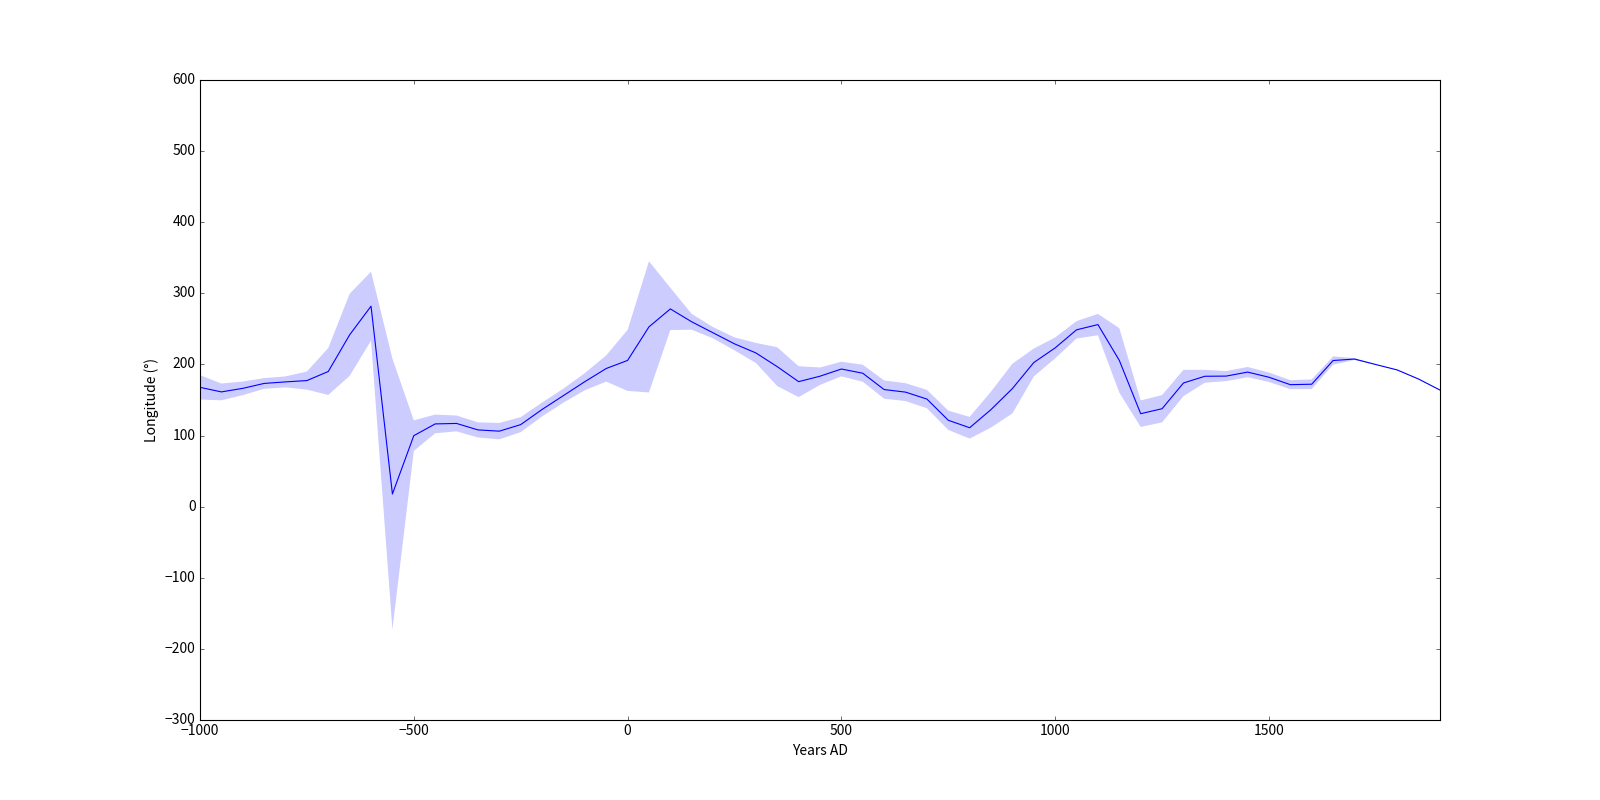

In [91]:
fig, ax = pyplot.subplots(figsize=(20,10))

ax.plot(sha.years, scipy.rad2deg(phi), "b-")
ax.fill_between(sha.years, scipy.rad2deg(phi-phi_dev), scipy.rad2deg(phi+phi_dev), lw=0, alpha=0.2)

ax.set_xlabel("Years AD")
ax.set_ylabel("Longitude (°)")

ax.set_xbound(-1000, sha.years[-1])

pyplot.show(fig)

In [61]:
p_dip=dipole.power(sha.gcomp, lmin=1, lmax=1)
p_quad=dipole.power(sha.gcomp, lmin=2, lmax=2)

In [80]:
power=dipole.power(sha.gcomp, lmin=1, lmax=2, separated=True)
p_sym=power[:,0]+power[:,3]
p_asym=power[:,1:3].sum(axis=1)+power[:,4:8].sum(axis=1)

<IPython.core.display.Javascript object>


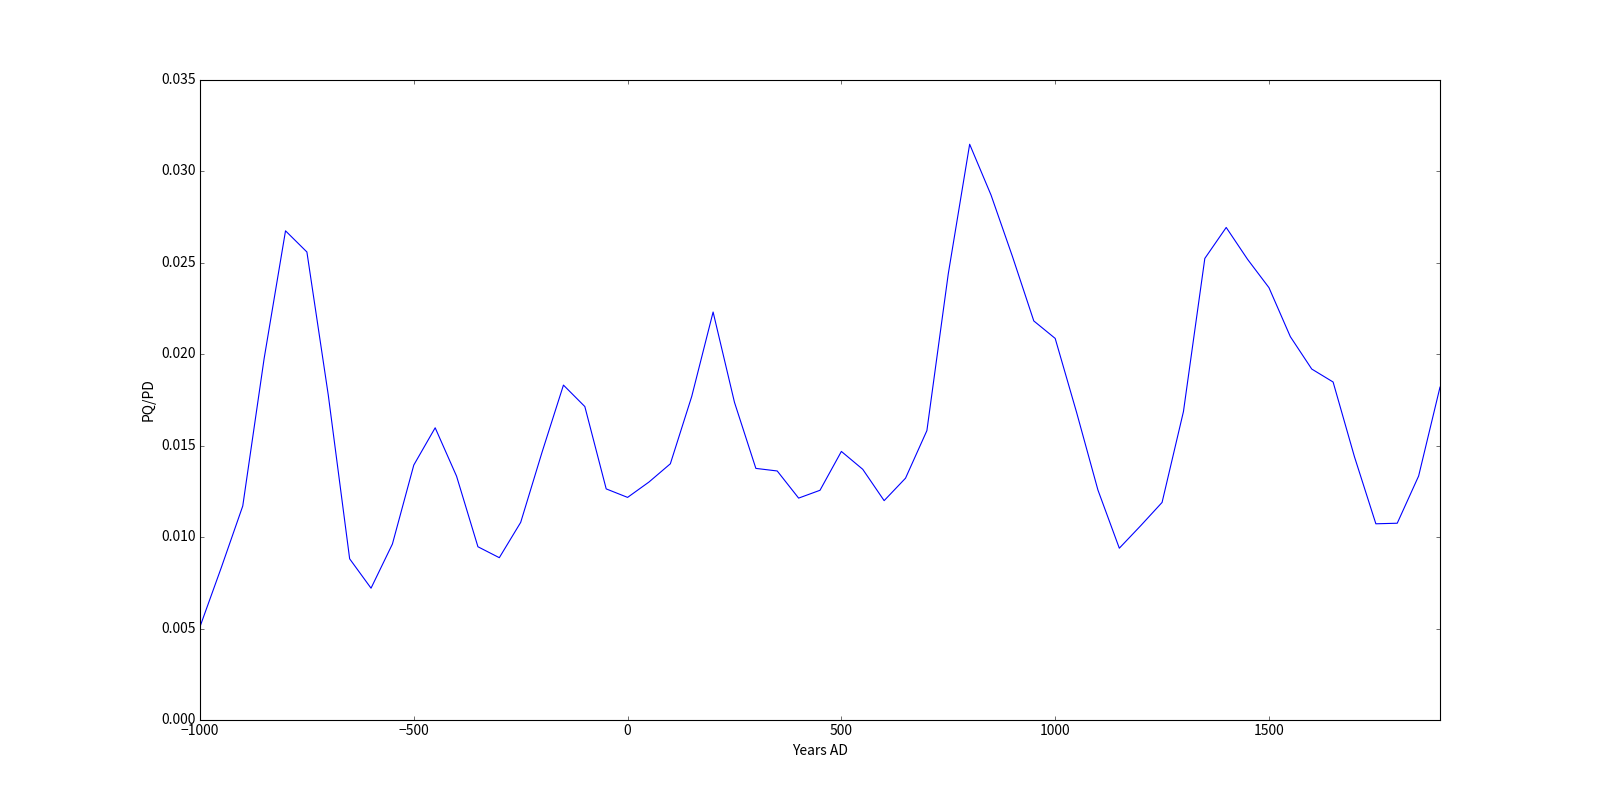

In [92]:
fig, ax = pyplot.subplots(figsize=(20,10))

#ax.plot(sha.years, p_dip)
#ax.plot(sha.years, p_quad)

ax.plot(sha.years, p_quad/p_dip)

ax.set_xbound(-1000, sha.years[-1])
ax.set_xlabel("Years AD")
ax.set_ylabel("PQ/PD")
pyplot.show(fig)

<IPython.core.display.Javascript object>


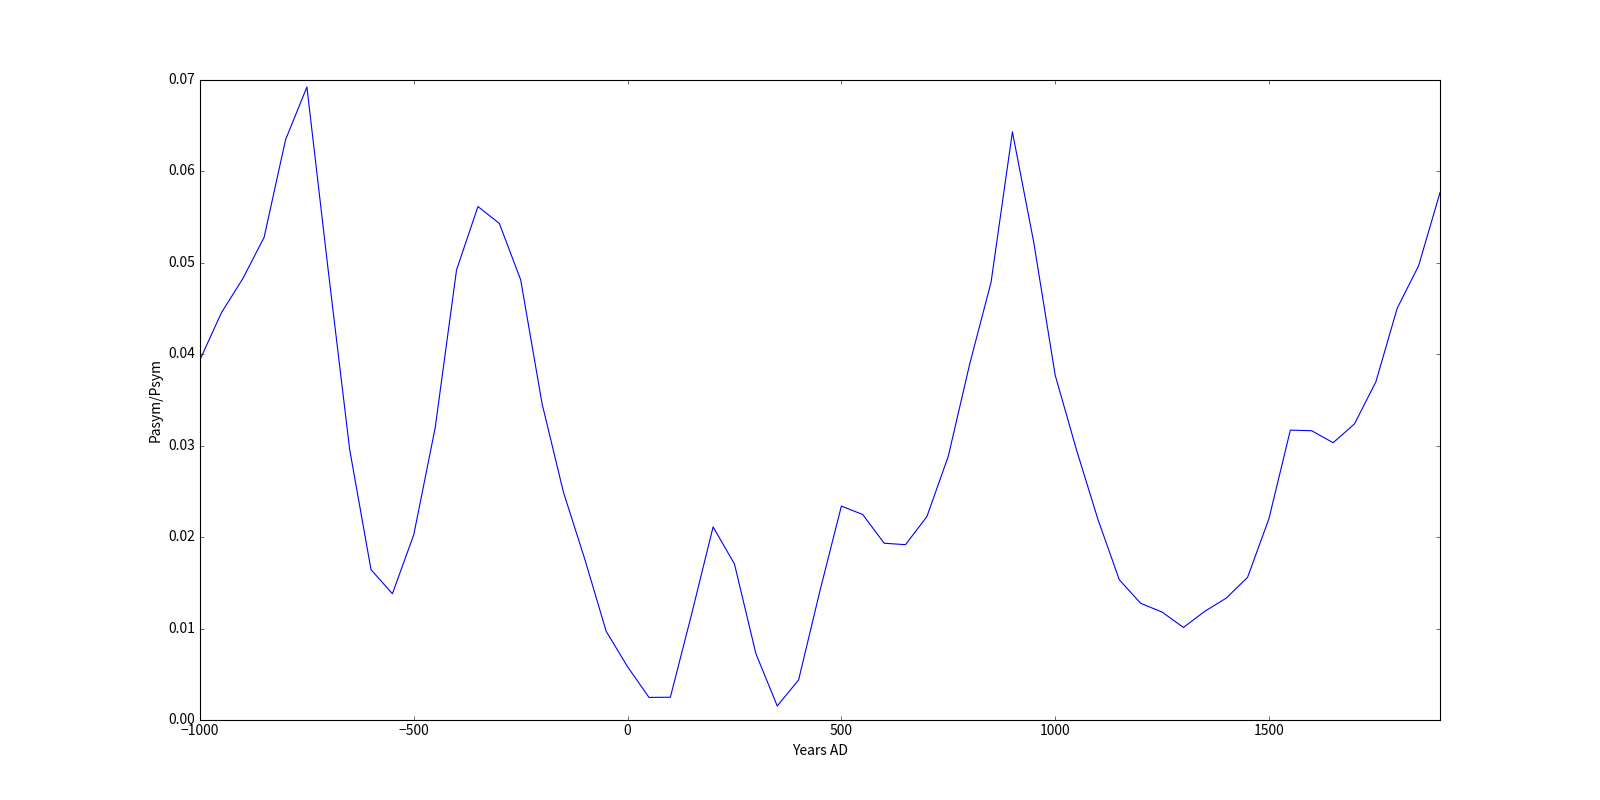

In [83]:
fig, ax = pyplot.subplots(figsize=(20,10))

#ax.plot(sha.years, p_dip)
#ax.plot(sha.years, p_quad)

ax.plot(sha.years, p_asym/p_sym)

ax.set_xbound(-1000, sha.years[-1])
ax.set_xlabel("Years AD")
ax.set_ylabel("Pasym/Psym")
pyplot.show(fig)

In [8]:
from mpl_toolkits import mplot3d

<IPython.core.display.Javascript object>


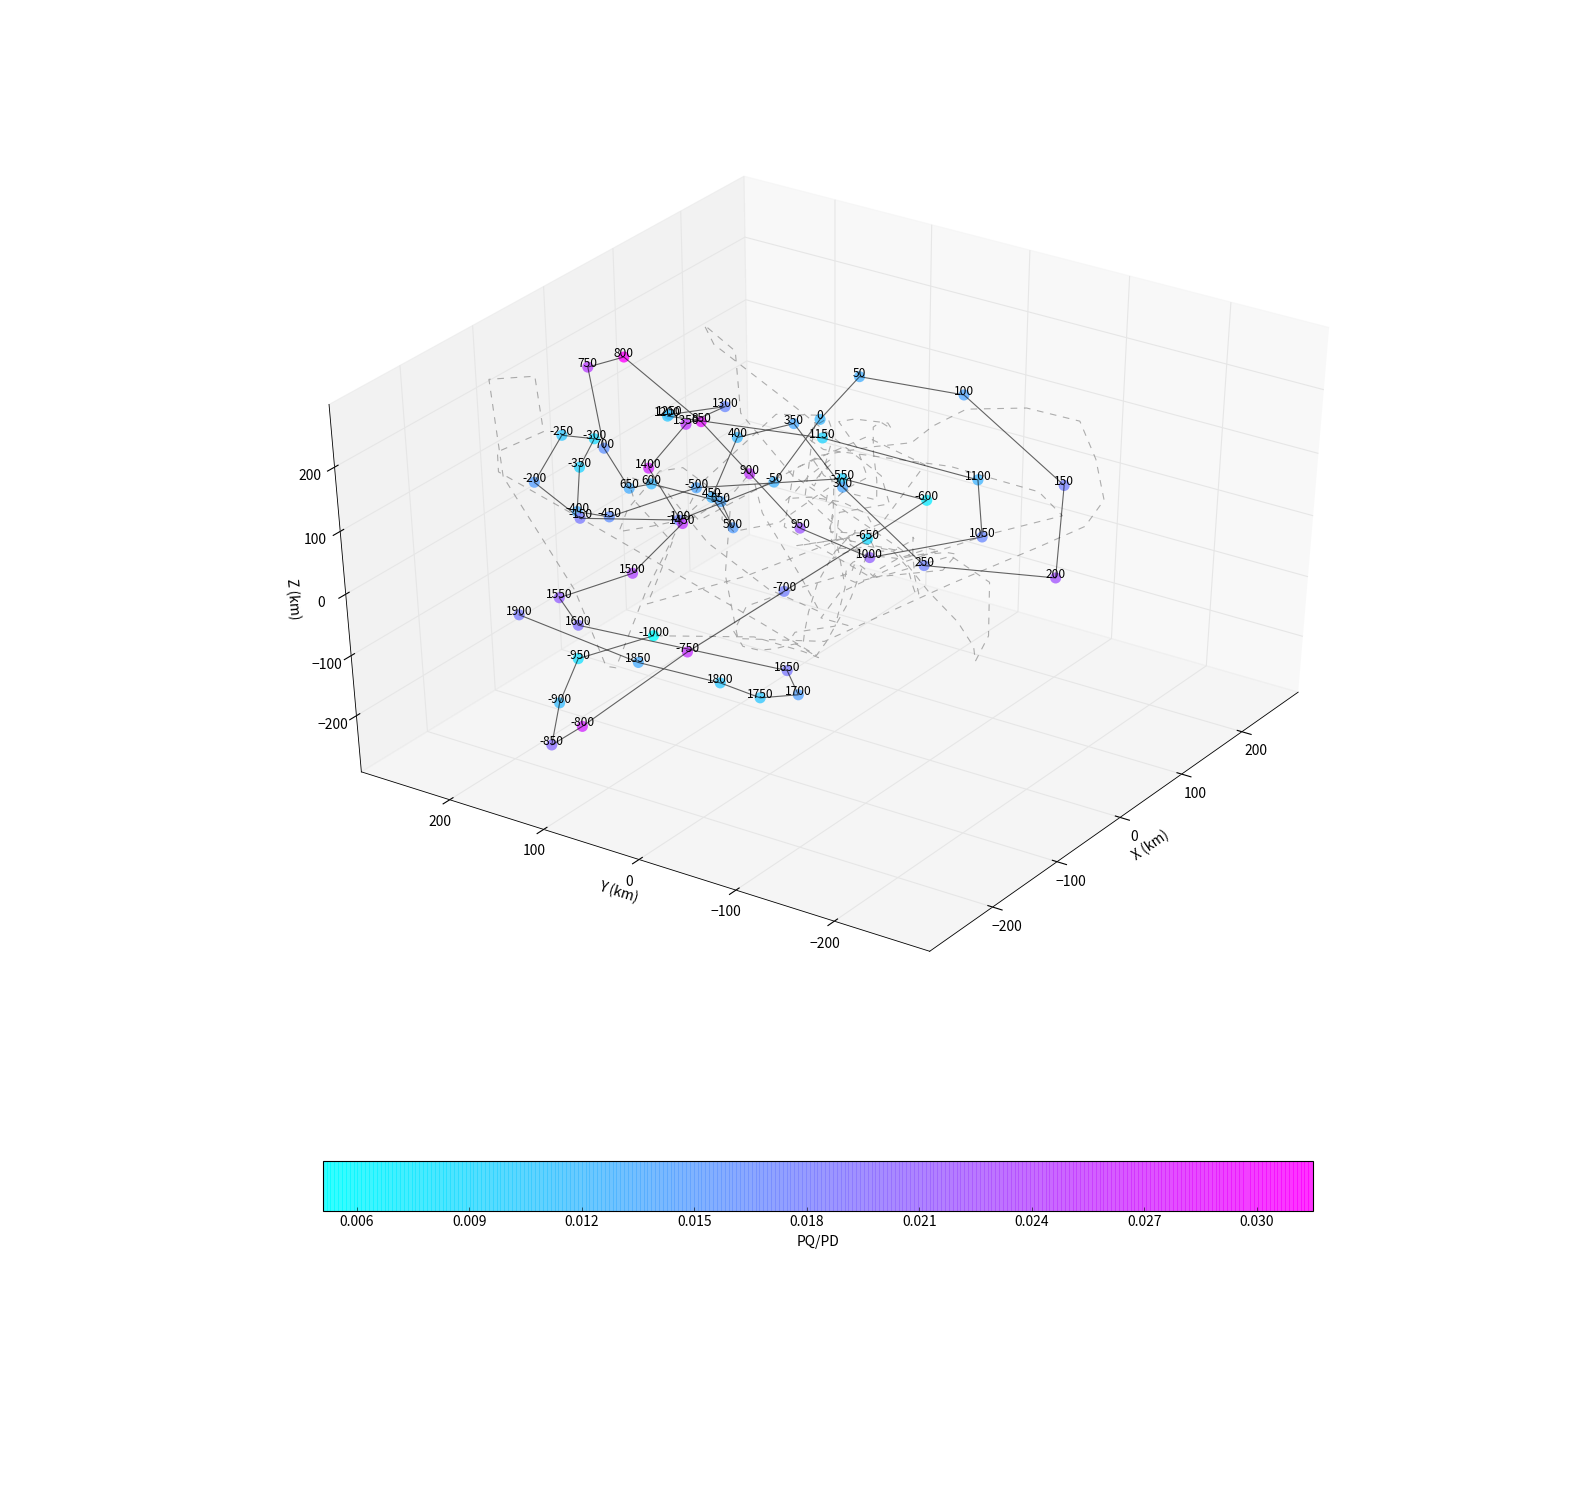

In [85]:
fig = pyplot.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

years = numpy.array(sha.years)

ax.plot(x[years >= -1000],y[years >= -1000],z[years >= -1000], alpha=0.6, color="black")
ax.plot(x[years <= -1000],y[years <= -1000],z[years <= -1000], alpha=0.3, color="black", ls="--")

xs = x[years >= -1000]; ys=y[years >= -1000]; zs=z[years >= -1000]; ts=years[years >= -1000]

for xi,yi,zi,ti in zip(xs,ys,zs,ts):
    ax.text(xi,yi,zi,str(int(ti)), fontsize=12, horizontalalignment="center")
       
c=ax.scatter(xs,ys,zs,
           #s=(30000*p_quad/p_dip)[years >= -1000],
           #c="b",
           c=(p_quad/p_dip)[years >= -1000],
           s=100,
           lw=0, alpha=0.8,
           cmap="cool")

ax.set_xbound(-max(abs(r))*1.05, max(abs(r))*1.05)
ax.set_ybound(-max(abs(r))*1.05, max(abs(r))*1.05)
ax.set_zbound(-max(abs(r))*1.05, max(abs(r))*1.05)

pyplot.colorbar(mappable=c, ax=ax, label="PQ/PD", orientation="horizontal", shrink=0.8)

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")

<IPython.core.display.Javascript object>


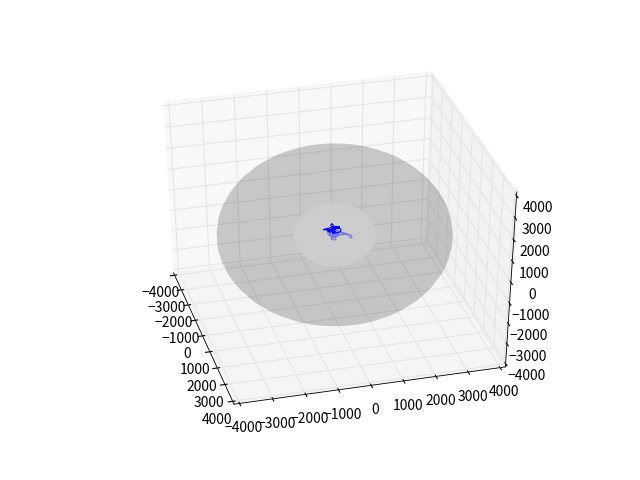

In [84]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

years = numpy.array(sha.years)

ax.plot(x[years >= -1000],y[years >= -1000],z[years >= -1000])
ax.plot(x[years <= -1000],y[years <= -1000],z[years <= -1000], alpha=0.4, color="blue")


u = numpy.linspace(0, 2 * numpy.pi, 100)
v = numpy.linspace(0, numpy.pi, 100)

xn = 3520 * numpy.outer(numpy.cos(u), numpy.sin(v))
yn = 3520 * numpy.outer(numpy.sin(u), numpy.sin(v))
zn = 3520 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
ax.plot_surface(xn, yn, zn, rstride=4, cstride=4, color='k', linewidth=0, shade=False, alpha=0.1)
xn = 1220 * numpy.outer(numpy.cos(u), numpy.sin(v))
yn = 1220 * numpy.outer(numpy.sin(u), numpy.sin(v))
zn = 1220 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
ax.plot_surface(xn, yn, zn, rstride=4, cstride=4, color='w', linewidth=0, shade=False, alpha=1.0)

ax.scatter(x[-1],y[-1],z[-1])

In [86]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))